# Entrenamiento Profesional LSTM Seq2Seq con Integración AEMET

Este notebook implementa un pipeline reproducible para entrenar un modelo LSTM Seq2Seq que predice niveles de embalse a múltiples horizontes.

Para simular un entorno operativo realista, el modelo consume:
- **Historial observado**: niveles, precipitación, temperatura, caudal y variables AEMET (temperatura media, precipitación, humedad, viento).
- **Pseudo-pronósticos**: valores futuros con ruido añadido (σ=5%) para emular la incertidumbre de predicciones meteorológicas reales.

Esto evita la fuga de información ("hacer trampas") y permite evaluar el modelo en condiciones cercanas al uso operativo, donde las previsiones meteorológicas no son perfectas.

**Justificación hidrológica**: El balance hídrico de un embalse depende de aportes (precipitación, escorrentía) y pérdidas (evaporación, desembalse) futuras. Integrar pronósticos meteorológicos reduce la incertidumbre de la predicción.

In [4]:
# Dependencies
import os
import random
import json
import datetime
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List
import torch
import torch.nn as nn
import matplotlib

from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Main hyperparameters
LOOKBACK = 360 # Days before prediction
HORIZON = 180 # Days to predict ahead
BATCH_SIZE = 32  # Batch size for training
EPOCHS = 100 # Number of training epochs
LR = 1e-3 # Learning rate
WEIGHT_DECAY = 1e-3  # Added: Helps prevent overfitting.
DROPOUT = 0.4 # Increased: Forces the model to be less dependent on specific data.
HIDDEN_SIZE = 64 # Size of hidden layers.
NUM_LAYERS = 2 # Number of layers in the model.
SIGMA_FORECAST = 0.02 # Uncertainty in forecasts

print(f"Seeds set: SEED={SEED}")
print(f"Device: {DEVICE}")
print(f"Configuration: LOOKBACK={LOOKBACK}, HORIZON={HORIZON}, LR={LR}, SIGMA={SIGMA_FORECAST}")

Seeds set: SEED=42
Device: cpu
Configuration: LOOKBACK=360, HORIZON=180, LR=0.001, SIGMA=0.02


In [6]:
#  Load data from csv
DATA_CSV = os.path.join(os.getcwd(), 'data', 'dataset_embalses_aemet.csv')
if not os.path.exists(DATA_CSV):
    DATA_CSV = os.path.join(os.getcwd(), 'dataset_embalses_aemet.csv')

# Data preprocessing
df = pd.read_csv(DATA_CSV)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha']).sort_values(['codigo_saih','fecha'])

# Convert columns to numeric types
numeric_cols = ['nivel','precipitacion','temperatura','caudal_promedio',
                'tmed','prec','tmin','tmax','hr_media','velmedia','racha']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing AEMET data with zeros
aemet_cols = ['tmed','prec','tmin','tmax','hr_media','velmedia','racha']
for col in aemet_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0.0)

# Filter records with missing 'nivel'
df = df.dropna(subset=['nivel'])

# Filter stations with sufficient length
min_len = LOOKBACK + HORIZON + 10
valid_stations = [e for e, g in df.groupby('codigo_saih') if len(g) >= min_len]
df = df[df['codigo_saih'].isin(valid_stations)]

print(f"Valid stations: {len(valid_stations)} | Records: {len(df)}")
print(f"Available columns: {list(df.columns)}")
df.head(3)

Valid stations: 30 | Records: 116044
Available columns: ['codigo_saih', 'fecha', 'nivel', 'precipitacion', 'temperatura', 'caudal_promedio', 'provincia', 'tmed', 'prec', 'tmin', 'tmax', 'hr_media', 'velmedia', 'racha']


,codigo_saih,fecha,nivel,precipitacion,temperatura,caudal_promedio,provincia,tmed,prec,tmin,tmax,hr_media,velmedia,racha
0,E001,2015-01-01,306.13,0.0,3.02,14.69,LUGO,6.800000,0.2,-5.9,16.3,67.000000,0.866667,6.7
1,E001,2015-01-02,305.85,0.0,3.22,82.04,LUGO,7.072727,0.0,-4.9,16.7,68.727273,1.033333,5.3
2,E001,2015-01-03,306.15,0.0,4.14,13.51,LUGO,7.909091,0.0,-4.4,16.3,67.090909,1.200000,11.1


In [7]:
# Normalization and window creation with pseudo-forecasts
def multistep_windows(df: pd.DataFrame, lookback: int, horizon: int, sigma: float = SIGMA_FORECAST) -> Tuple[np.ndarray, np.ndarray, List[Tuple[str, pd.Timestamp]], Dict[str, MinMaxScaler], List[str]]:
    """
    Creates windows with:
      - Observed history: hydro + AEMET meteorological data
      - Pseudo-forecasts: future values + Gaussian noise to simulate uncertainty
    
    Returns:
        X: array (N, lookback, features)
        Y: array (N, horizon)
        idx_pairs: list of (station, start_date)
        scalers: dict of scalers per station
        hist_cols: list of used columns
    """
    X, y = [], []
    idx_pairs = []
    scalers: Dict[str, MinMaxScaler] = {}
    
    # Columns to use for historical data
    base_cols = ['nivel','precipitacion','temperatura','caudal_promedio',
                 'tmed','prec','tmin','tmax','hr_media','velmedia','racha']
    hist_cols = [c for c in base_cols if c in df.columns]
    n_feat = len(hist_cols)
    
    for estacion, g in df.groupby('codigo_saih'):
        g = g.sort_values('fecha').set_index('fecha')
        if len(g) < lookback + horizon + 1:
            continue
        
        scaler = MinMaxScaler()
        scaled_hist = pd.DataFrame(
            scaler.fit_transform(g[hist_cols]),
            index=g.index,
            columns=hist_cols
        )
        scalers[estacion] = scaler
        
        for i in range(lookback, len(scaled_hist) - horizon):
            # Historical window
            hist_window = scaled_hist.iloc[i-lookback:i].values  # (lookback, n_feat)
            
            # Pseudo-forecast: future observed + noise
            fut_real = scaled_hist.iloc[i:i+horizon].values     # (horizon, n_feat)
            noise = np.random.normal(loc=0.0, scale=sigma, size=fut_real.shape)
            fut_forecast = np.clip(fut_real + noise, 0.0, 1.0)
            
            # Forecast summary: mean per feature
            fut_summary = fut_forecast.mean(axis=0)              # (n_feat,)
            fut_tiled = np.tile(fut_summary, (lookback, 1))      # (lookback, n_feat)
            
            # Concatenate history + forecast
            x_win = np.hstack([hist_window, fut_tiled])          # (lookback, 2*n_feat)
            X.append(x_win)
            
            # Target: future nivel only
            y.append(scaled_hist.iloc[i:i+horizon]['nivel'].values)
            idx_pairs.append((estacion, scaled_hist.index[i]))
    
    X = np.array(X)
    Y = np.array(y)
    print(f"- Features históricas: {hist_cols}")
    print(f"-  Input shape por ventana: ({lookback}, {n_feat} hist + {n_feat} forecast = {2*n_feat})")
    return X, Y, idx_pairs, scalers, hist_cols

# Execute window creation
X, Y, idx_pairs, scalers, HIST_COLS = multistep_windows(df, LOOKBACK, HORIZON)
print(f"Windows created: X={X.shape}, Y={Y.shape}")

- Features históricas: ['nivel', 'precipitacion', 'temperatura', 'caudal_promedio', 'tmed', 'prec', 'tmin', 'tmax', 'hr_media', 'velmedia', 'racha']
-  Input shape por ventana: (360, 11 hist + 11 forecast = 22)
Windows created: X=(99844, 360, 22), Y=(99844, 180)


In [8]:
# Create PyTorch datasets and dataloaders
class EmbalsesDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

N = len(X)
split1 = int(0.8 * N)
split2 = int(0.9 * N)

train_ds = EmbalsesDataset(X[:split1], Y[:split1])
val_ds   = EmbalsesDataset(X[split1:split2], Y[split1:split2])
test_ds  = EmbalsesDataset(X[split2:], Y[split2:])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

len(train_ds), len(val_ds), len(test_ds)

(79875, 9984, 9985)

In [9]:
# LTSM Seq2Seq Model
FEATURES = X.shape[-1]  # dynamically calculated after window creation

class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size=FEATURES, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT, horizon=HORIZON):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_size, horizon)
        self._init_weights()
    def _init_weights(self):
        for name, param in self.encoder.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        h = self.dropout(h_n[-1])
        out = self.fc_out(h)
        return out

In [10]:
# Training loop with early stopping and LR scheduler
class EarlyStopping:
    def __init__(self, patience=7, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()
    return total / len(loader)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total += loss.item()
    return total / len(loader)

In [8]:
# Create model
model = LSTMSeq2Seq().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()
print(f"Model initialized: input_size={FEATURES}, hidden={HIDDEN_SIZE}, layers={NUM_LAYERS}")
print(model)

Model initialized: input_size=22, hidden=64, layers=2
LSTMSeq2Seq(
  (encoder): LSTM(22, 64, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc_out): Linear(in_features=64, out_features=180, bias=True)
)


In [9]:
# Train
history = {'train': [], 'val': []}
early = EarlyStopping(patience=7, min_delta=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

# Save in Models with unique timestamp (includes time to avoid overwriting)
date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(os.getcwd(), 'Models', f'model_{date_str}')
os.makedirs(model_dir, exist_ok=True)

best_path = os.path.join(model_dir, f'model_{date_str}.pth')
scalers_path = os.path.join(model_dir, f'scalers_{date_str}.npy')

best_val = float('inf')
print(f"Starting training: maximum {EPOCHS} epochs")
print(f"Model will be saved to: {model_dir}\n")

for epoch in range(1, EPOCHS+1):
    tl = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    vl = eval_epoch(model, val_loader, criterion, DEVICE)
    history['train'].append(tl)
    history['val'].append(vl)
    scheduler.step(vl)

    if vl < best_val:
        best_val = vl
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'config': {
                'LOOKBACK': LOOKBACK, 'HORIZON': HORIZON, 'BATCH_SIZE': BATCH_SIZE,
                'LR': LR, 'WEIGHT_DECAY': WEIGHT_DECAY, 'HIDDEN_SIZE': HIDDEN_SIZE,
                'NUM_LAYERS': NUM_LAYERS, 'DROPOUT': DROPOUT, 'FEATURES': FEATURES,
                'HIST_COLS': HIST_COLS, 'SIGMA_FORECAST': SIGMA_FORECAST
            },
            'best_val': best_val,
            'epoch': epoch
        }, best_path)
        
        # Save scalers separately (sklearn not compatible with weights_only=True)
        np.save(scalers_path, scalers, allow_pickle=True)

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Train {tl:.4f} | Val {vl:.4f} | Best {best_val:.4f}")
    if early.step(vl):
        print(f"Early stopping at epoch {epoch}")
        break

# Save artifacts
artifacts_dir = os.path.join(model_dir, 'artifacts')
os.makedirs(artifacts_dir, exist_ok=True)

metrics_path = os.path.join(artifacts_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump({
        'seed': SEED,
        'device': str(DEVICE),
        'model_timestamp': date_str,
        'config': {
            'LOOKBACK': LOOKBACK, 'HORIZON': HORIZON, 'BATCH_SIZE': BATCH_SIZE,
            'LR': LR, 'WEIGHT_DECAY': WEIGHT_DECAY, 'HIDDEN_SIZE': HIDDEN_SIZE,
            'NUM_LAYERS': NUM_LAYERS, 'DROPOUT': DROPOUT, 'FEATURES': FEATURES,
            'SIGMA_FORECAST': SIGMA_FORECAST, 'HIST_COLS': HIST_COLS
        },
        'training_history': {
            'train_loss': history['train'],
            'val_loss': history['val']
        },
        'best_val_loss': float(best_val),
        'total_epochs': len(history['train'])
    }, f, indent=2)

print(f"\nTraining completed. Best validation: {best_val:.4f}")
print(f"Checkpoint saved at: {best_path}")
print(f"Scalers saved at: {scalers_path}")
print(f"Metrics saved at: {metrics_path}")
print(f"\nTo test this model, use: MODEL_NAME = 'model_{date_str}'")

Starting training: maximum 100 epochs
Model will be saved to: /home/migui/master/TFM/aquaia/training/Models/model_20260114_193518

Epoch 005 | Train 0.0266 | Val 0.0211 | Best 0.0208
Epoch 010 | Train 0.0266 | Val 0.0216 | Best 0.0208
Early stopping at epoch 10

Training completed. Best validation: 0.0208
Checkpoint saved at: /home/migui/master/TFM/aquaia/training/Models/model_20260114_193518/model_20260114_193518.pth
Scalers saved at: /home/migui/master/TFM/aquaia/training/Models/model_20260114_193518/scalers_20260114_193518.npy
Metrics saved at: /home/migui/master/TFM/aquaia/training/Models/model_20260114_193518/artifacts/metrics.json

To test this model, use: MODEL_NAME = 'model_20260114_193518'


Modelos disponibles (1):
  1. model_20260114_193518

Evaluando modelo: model_20260114_193518

Model configuration:
  - LOOKBACK: 360
  - HORIZON: 180
  - FEATURES: 22
  - HIDDEN_SIZE: 64
  - NUM_LAYERS: 2
  - DROPOUT: 0.4
  - Best val loss: 0.0208
  - Epochs trained: 10

✓ Model loaded from: /home/migui/master/TFM/aquaia/training/Models/model_20260114_193518/model_20260114_193518.pth
✓ Scalers loaded from: /home/migui/master/TFM/aquaia/training/Models/model_20260114_193518/scalers_20260114_193518.npy

Evaluation metrics:
  - MAE day 1: 0.2129
  - RMSE day 1: 0.2787
  - Average MAE (30 days): 0.1909
  - Average RMSE (30 days): 0.2543



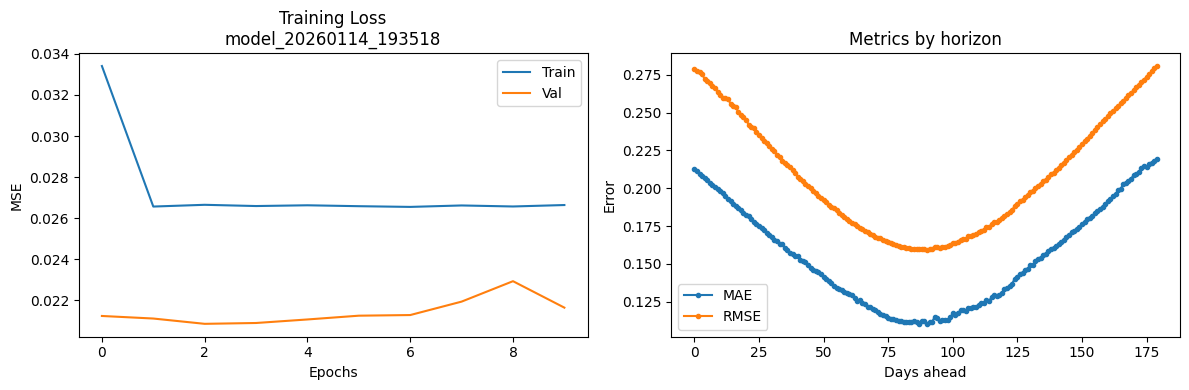

In [11]:
# Testing and evaluation - Load any trained model
models_base_dir = os.path.join(os.getcwd(), 'Models')
available_models = [d for d in os.listdir(models_base_dir) 
                   if os.path.isdir(os.path.join(models_base_dir, d)) and d.startswith('model_')]
print(f"Modelos disponibles ({len(available_models)}):")
for i, model_name in enumerate(sorted(available_models), 1):
    print(f"  {i}. {model_name}")

MODEL_NAME = sorted(available_models)[-1] if available_models else f'model_{date_str}' # Last Model

print(f"\n{'='*60}")
print(f"Evaluando modelo: {MODEL_NAME}")
print(f"{'='*60}\n")

model_dir = os.path.join(models_base_dir, MODEL_NAME)
artifacts_dir = os.path.join(model_dir, 'artifacts')
metrics_path = os.path.join(artifacts_dir, 'metrics.json')

# Load saved metrics and config
with open(metrics_path, 'r') as f:
    saved_data = json.load(f)

# Extract model configuration
cfg = saved_data['config']
MODEL_LOOKBACK = cfg['LOOKBACK']
MODEL_HORIZON = cfg['HORIZON']
MODEL_FEATURES = cfg['FEATURES']
MODEL_HIDDEN_SIZE = cfg['HIDDEN_SIZE']
MODEL_NUM_LAYERS = cfg['NUM_LAYERS']
MODEL_DROPOUT = cfg['DROPOUT']
MODEL_HIST_COLS = cfg['HIST_COLS']

print(f"Model configuration:")
print(f"  - LOOKBACK: {MODEL_LOOKBACK}")
print(f"  - HORIZON: {MODEL_HORIZON}")
print(f"  - FEATURES: {MODEL_FEATURES}")
print(f"  - HIDDEN_SIZE: {MODEL_HIDDEN_SIZE}")
print(f"  - NUM_LAYERS: {MODEL_NUM_LAYERS}")
print(f"  - DROPOUT: {MODEL_DROPOUT}")
print(f"  - Best val loss: {saved_data['best_val_loss']:.4f}")
print(f"  - Epochs trained: {saved_data['total_epochs']}\n")

# Rebuild model with saved configuration
test_model = LSTMSeq2Seq(
    input_size=MODEL_FEATURES,
    hidden_size=MODEL_HIDDEN_SIZE,
    num_layers=MODEL_NUM_LAYERS,
    dropout=MODEL_DROPOUT,
    horizon=MODEL_HORIZON
).to(DEVICE)

# Load model weights
model_path = os.path.join(model_dir, f'{MODEL_NAME}.pth')
scalers_path = os.path.join(model_dir, f'scalers_{MODEL_NAME.replace("model_", "")}.npy')

ckpt = torch.load(model_path, map_location=DEVICE, weights_only=False)
test_model.load_state_dict(ckpt['model_state_dict'])
test_model.eval()

# Load scalers
loaded_scalers = np.load(scalers_path, allow_pickle=True).item()

print(f"✓ Model loaded from: {model_path}")
print(f"✓ Scalers loaded from: {scalers_path}\n")

# =========================================
# EVALUATION ON TEST SET
# =========================================
test_preds, test_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        pred = test_model(xb).cpu().numpy()
        test_preds.append(pred)
        test_true.append(yb.numpy())

test_preds = np.concatenate(test_preds)
test_true = np.concatenate(test_true)

# Metrics by horizon
eval_days = min(180, MODEL_HORIZON)
mae_h = [mean_absolute_error(test_true[:, h], test_preds[:, h]) for h in range(eval_days)]
rmse_h = [np.sqrt(mean_squared_error(test_true[:, h], test_preds[:, h])) for h in range(eval_days)]

print(f"Evaluation metrics:")
print(f"  - MAE day 1: {mae_h[0]:.4f}")
print(f"  - RMSE day 1: {rmse_h[0]:.4f}")
print(f"  - Average MAE (30 days): {np.mean(mae_h[:30]):.4f}")
print(f"  - Average RMSE (30 days): {np.mean(rmse_h[:30]):.4f}\n")

# Plot 
history_train = saved_data['training_history']['train_loss']
history_val = saved_data['training_history']['val_loss']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_train, label='Train')
plt.plot(history_val, label='Val')
plt.title(f'Training Loss\n{MODEL_NAME}')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mae_h, 'o-', label='MAE', markersize=3)
plt.plot(rmse_h, 'o-', label='RMSE', markersize=3)
plt.title('Metrics by horizon')
plt.xlabel('Days ahead')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()

# Estadísticas adicionales de predicción y precisión
A continuación se calculan métricas adicionales sobre el conjunto de test: $R^2$ por horizonte, porcentaje de predicciones con error absoluto bajo un umbral y estadísticas descriptivas del error.

In [12]:
# Detailed analysis
from sklearn.metrics import r2_score

# R2 by horizon (first 30 days)
eval_days_r2 = min(30, MODEL_HORIZON)
r2_h = [r2_score(test_true[:, h], test_preds[:, h]) for h in range(eval_days_r2)]

# Percentage of predictions with absolute error < 0.1 (you can adjust the threshold)
threshold = 0.1
pct_buenas = [(np.abs(test_true[:, h] - test_preds[:, h]) < threshold).mean()*100 for h in range(eval_days_r2)]

# Descriptive statistics of absolute error
abs_errors = np.abs(test_true[:, :eval_days_r2] - test_preds[:, :eval_days_r2])
mean_abs_error = abs_errors.mean(axis=0)
median_abs_error = np.median(abs_errors, axis=0)
std_abs_error = abs_errors.std(axis=0)

print(f"Detailed analysis for {MODEL_NAME}:")
print("="*60)
print("R2 by horizon (first 30 days):", np.round(r2_h, 3))
print(f"% of predictions with error < {threshold} by horizon:", np.round(pct_buenas, 1))
print("Mean absolute error by horizon:", np.round(mean_abs_error, 4))
print("Median absolute error by horizon:", np.round(median_abs_error, 4))
print("Standard deviation of absolute error by horizon:", np.round(std_abs_error, 4))

Detailed analysis for model_20260114_193518:
R2 by horizon (first 30 days): [0.093 0.099 0.106 0.115 0.134 0.143 0.152 0.163 0.173 0.188 0.199 0.213
 0.214 0.216 0.235 0.242 0.249 0.267 0.281 0.288 0.296 0.315 0.325 0.328
 0.341 0.354 0.364 0.374 0.383 0.393]
% of predictions with error < 0.1 by horizon: [33.5 34.4 35.  35.4 34.8 35.4 35.8 36.  36.5 36.3 36.7 36.3 38.  38.6
 38.5 38.9 39.5 39.5 39.5 40.1 40.7 40.1 40.4 41.7 41.8 41.7 42.1 42.2
 42.5 42.9]
Mean absolute error by horizon: [0.2129 0.2111 0.2094 0.2078 0.2069 0.2053 0.2037 0.2023 0.2007 0.1996
 0.198  0.1969 0.1945 0.1928 0.1915 0.1898 0.1883 0.1869 0.1855 0.1839
 0.1823 0.1814 0.1798 0.1778 0.1764 0.1751 0.1736 0.1722 0.1706 0.1691]
Median absolute error by horizon: [0.1646 0.162  0.1593 0.1573 0.1579 0.1556 0.1543 0.1533 0.151  0.1504
 0.1485 0.148  0.1435 0.1416 0.1409 0.1389 0.1367 0.1365 0.1362 0.1336
 0.1324 0.1338 0.1326 0.1288 0.1283 0.128  0.1272 0.1264 0.1254 0.1245]
Standard deviation of absolute error by horizo